<a href="https://colab.research.google.com/github/GilSasson/ai/blob/main/StocksFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Applications of Artificial Intelligence and Data Mining, Prof. Avi Rosenfeld.**
**Project:** Time series stock analysis

**Students:**

Gil Sasson

Dor Hayat

Maya Kaufman

# **Table of Contents**
1. Data setup (Apple) and stocks' indicators.
2. Decision Tree model.
3. Logistic Regression model.
4. Random Forest model.
5. Neural Network model using the stocks' indicators.
6. Neural Network model using the raw data.
7. Testing 1-6 on Amazon stocks.

## **1) Data setup and stocks' indicators**
First we'll create a binary field which indicates if the stocks' price went up or not. In this work this step will be done manually in Excel but can be easily written in python. We'll then create more fields such as the day of the month and year. Using the raw data, we'll then write functions for some known stocks' price indicators such as RSI, OBV and SMA for two different time periods (we chose 3 & 10 days) and then substract them (substraction of the same indicator but different time periods) in order to get a broader view of the prices' behaviour and then show the strong relation between the stocks' indicators to the aforementioned binary field with a simple graph.
## **2-3) Using Decision Tree and Logistic Regression**
We will use decision tree and logistic regression to predict if the stock price market for one of the FAANG companies goes the next day (we chose Apple).
## **4-6) RF & Using Keras to Build and Train Neural Networks**
We will start by training a Random Forest to get a performance baseline. Then we will use a neural network to predict if the stocks' price goes up the next day. We will use the Keras package to build and train the aforementioned neural network.
## **7) Testing 1-6 on Amazon stocks**
Running the same code with slight changes if there are no nulls rows in the data in the Amazon dataset.


# “FAANG” companies (Facebook, Amazon, Apple, Netflix, Google)   database
source: https://www.kaggle.com/aayushmishra1512/faang-complete-stock-data

# Attributes (raw data):

1. Open - opening price of the stock
2. High - max pice of the stock for the day
3. Low - min price of the stock for the day
4. Close - closing price of stock for the day
5. Volume - volume are the physical number of shares traded of that stock on a particular day
6. Raise - determines if the stocks' price went up (0 or 1).

7. Adj Close - Data is adjusted using appropriate split and dividend multipliers for the closing price for the day and can be thought of as a more accurate measure of stocks’ value. Therefore, we'll use the Adj Close values to determine if the stocks' price went up the next day. 



The “FAANG” companies Dataset has 6 numerical predictors and a binary outcome.
We will add more indicators to the Dataset such as RSI, Moving Averages, OBV, which we will talk about later in this work.

In [ ]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns

%matplotlib inline

In [ ]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
#from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.utils.vis_utils import plot_model

In [ ]:
#Taken from tcoil [1] (See references)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
# From sentdex (Youtuber) [2] (See references)
def movingaverage(values,window):
  weights = np.repeat(1.0, window)/window
  smas = np.convolve(values, weights, mode='same')
  return smas

**1) Data Setup**

In [ ]:
#getting the dataset
url = 'https://raw.githubusercontent.com/GilSasson/ai/main/Apple2.csv'
df=pd.read_csv(url,  header=0, error_bad_lines=False) 
#put data in dataset without header line
# rawdataset = np.array(df)

We modified our Apple.csv file as follows:
1. We created a binary field to show if the stock went up or down.
2. We created a day of the month field because of the strong dependant of the stock's price because of trading days, holidays, et cetera.

Note: This algorithm does not take into account other strong stock-related features such as entrepreneurs' twits, social media, news et cetera et cetera.

If there are lots of "NaN" you may have internet connectivity issues.

In [ ]:
#dropping null values if such exists from np and df

print("shape off dataframe before drop:",df.shape)
# print("shape of np before drop:",rawdataset.shape)
null_row = np.where(df['Low'].isnull()) 
# dataset = np.delete(rawdataset,(null_row[0][0]), axis=0)
# print("shape of np after drop:",dataset.shape)
df.drop(null_row[0][0], axis=0, inplace = True)
print("shape of dataframe after drop:",df.shape)
print("row where we found null is:")
nullrow = null_row[0][0] # we had a null row here
nullrow

shape off dataframe before drop: (10016, 11)
shape of dataframe after drop: (10015, 11)
row where we found null is:


165

In [ ]:
#Creating new features with our given data:
High = df['High'].to_numpy()
Low = df['Low'].to_numpy()
Mid = (High+Low)/2.0
Close = df['Close'].to_numpy()
Open = df['Open'].to_numpy()
Volume = df['Volume'].to_numpy()
df.insert(2, "Mid", Mid, True)
df['RSI_10'] = computeRSI(df['Adj Close'], 4)
df['SMA_10'] = movingaverage(df['Adj Close'], 4)
df['RSI_3'] = computeRSI(df['Adj Close'], 2)
df['SMA_3'] = movingaverage(df['Adj Close'], 2)
df['SMA_SUB'] = df['SMA_10']-df['SMA_3']

At the beginning of the dataframe there are no RSI values calculated, since we need to calculate them using sufficient time window (10 days), let us get rid of the NaN values!

In [ ]:
#dropping nan values if such exists from df

print("shape off dataframe before drop:",df.shape)
dfrowsold = df.shape[0] # will be used for OBV calc
df.dropna(subset = ["RSI_10"], inplace=True)
print("shape of dataframe after drop:",df.shape)
dfrowsnew = df.shape[0] # will be used for OBV calc

shape off dataframe before drop: (10015, 17)
shape of dataframe after drop: (10011, 17)


Text(0, 0.5, 'SMA')

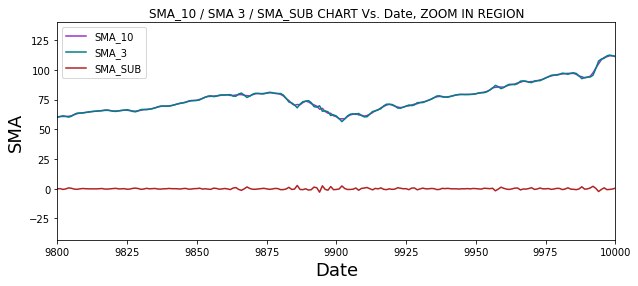

In [ ]:
#graphing SMA vs. Timeline
plt.figure(figsize=(10,4))
plt.title('SMA_10 / SMA 3 / SMA_SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['SMA_10'], label='SMA_10', color = 'darkorchid')
plt.plot(df['SMA_3'], label='SMA_3', color='teal')
plt.plot(df['SMA_SUB'], label='SMA_SUB', color='firebrick')
plt.xlim(9800,10000)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SMA', fontsize = 18)

Text(0, 0.5, 'SMA_SUB / Raise')

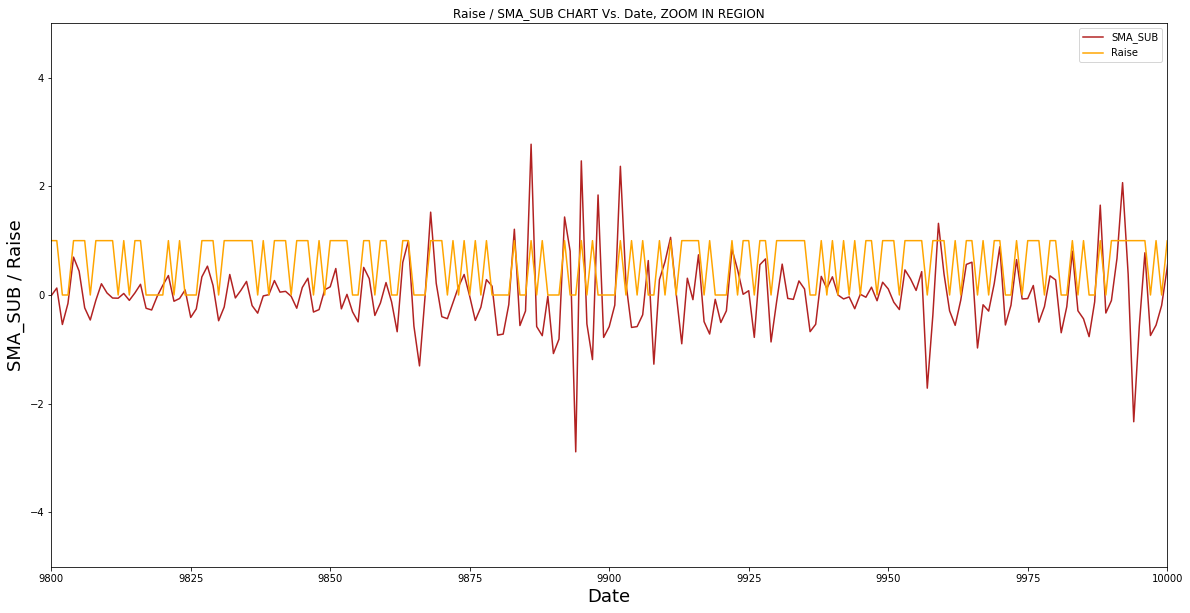

In [ ]:
#graphing OBV_SUB vs Raise.
plt.figure(figsize=(20,10))
plt.title('Raise / SMA_SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['SMA_SUB'], label='SMA_SUB', color='firebrick')
plt.plot(df['Raise'], label='Raise', color='orange')
plt.xlim(9800,10000)
plt.ylim(-5,5)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SMA_SUB / Raise', fontsize = 18)

In the graph above we can see the strong connection between SMA_SUB to Raise.

Text(0, 0.5, 'OBV')

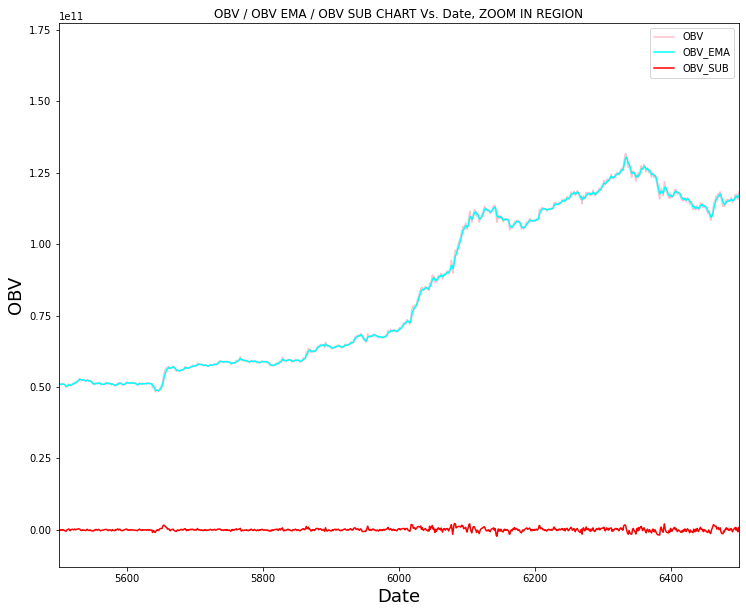

In [ ]:
#let's add one more indicator to our features' arsenal

#Calculation of On Balance Volume [3] (See References):
#If the closing price is above the prior close price then: Current OBV = Previous OBV + Current Volume
#If the closing price is below the prior close price then: Current OBV = Previous OBV - Current Volume
#If the closing prices equals the prior close price then: Current OBV = Previous OBV (no change)

OBV = []
OBV.append(0)
for i in range(dfrowsold-dfrowsnew+1 , nullrow):
  if df.Close[i] > df.Close[i-1]:
    OBV.append(OBV[-1] + df.Volume[i])
  elif df.Close[i] < df.Close[i-1]: 
    OBV.append(OBV[-1] - df.Volume[i])
  else:
    OBV.append(OBV[-1])
l=len(OBV)
for i in range(nullrow , dfrowsold):
  if i == nullrow:
    OBV.append(OBV[l-1])
  elif i == nullrow+1:
    OBV.append(OBV[l-1])
  elif df.Close[i] > df.Close[i-1]:
    OBV.append(OBV[-1] + df.Volume[i])
  elif df.Close[i] < df.Close[i-1]: 
    OBV.append(OBV[-1] - df.Volume[i])
  else:
    OBV.append(OBV[-1])
len(OBV)
#let's store the OBV and the EMA (exponential moving average) into new columns. [4] 
df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(span=4).mean()
df['OBV_SUB'] = df['OBV']-df['OBV_EMA']
#graphing OBV & OBV_EMA vs. Timeline
plt.figure(figsize=(12.2,10))
plt.title('OBV / OBV EMA / OBV SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['OBV'], label='OBV', color = 'pink')
plt.plot(df['OBV_EMA'], label='OBV_EMA', color='cyan')
plt.plot(df['OBV_SUB'], label='OBV_SUB', color='red')
plt.xlim(5500,6500)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('OBV', fontsize = 18)

Text(0, 0.5, 'OBV_SUB / Raise')

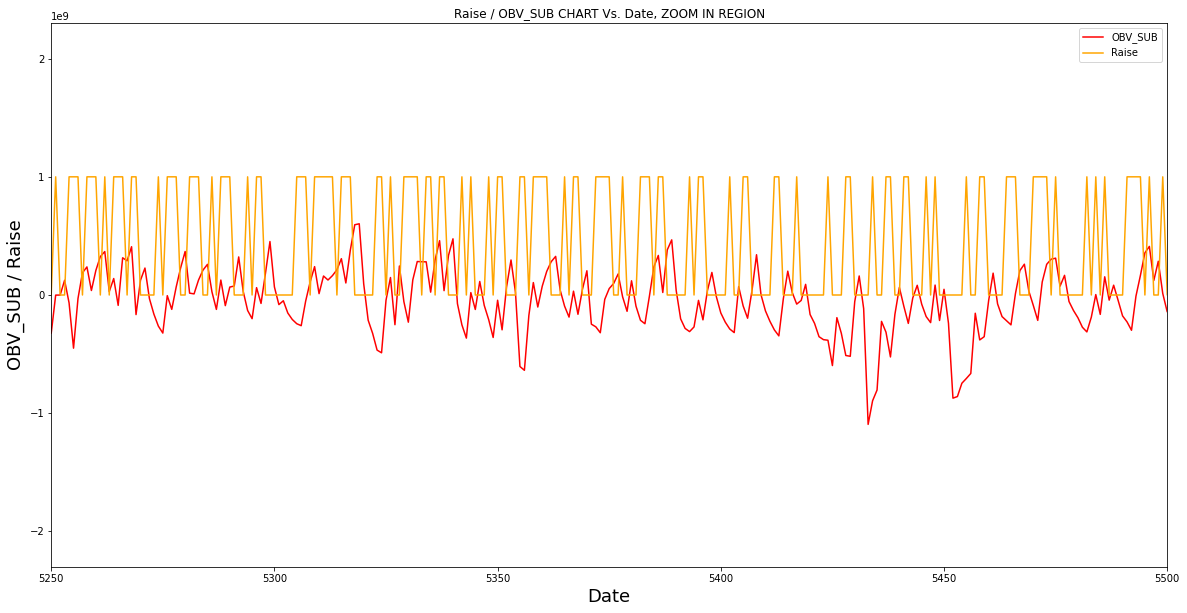

In [ ]:
#graphing OBV_SUB vs Raise.
plt.figure(figsize=(20,10))
plt.title('Raise / OBV_SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['OBV_SUB'], label='OBV_SUB', color='red')
plt.plot(df['Raise']*1000000000, label='Raise', color='orange')
plt.xlim(5250,5500)
plt.ylim(-2300000000,2300000000)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('OBV_SUB / Raise', fontsize = 18)

In the graph above we can see the strong connection between OBV_SUB to Raise.

Text(0, 0.5, 'RSI_3 / Raise')

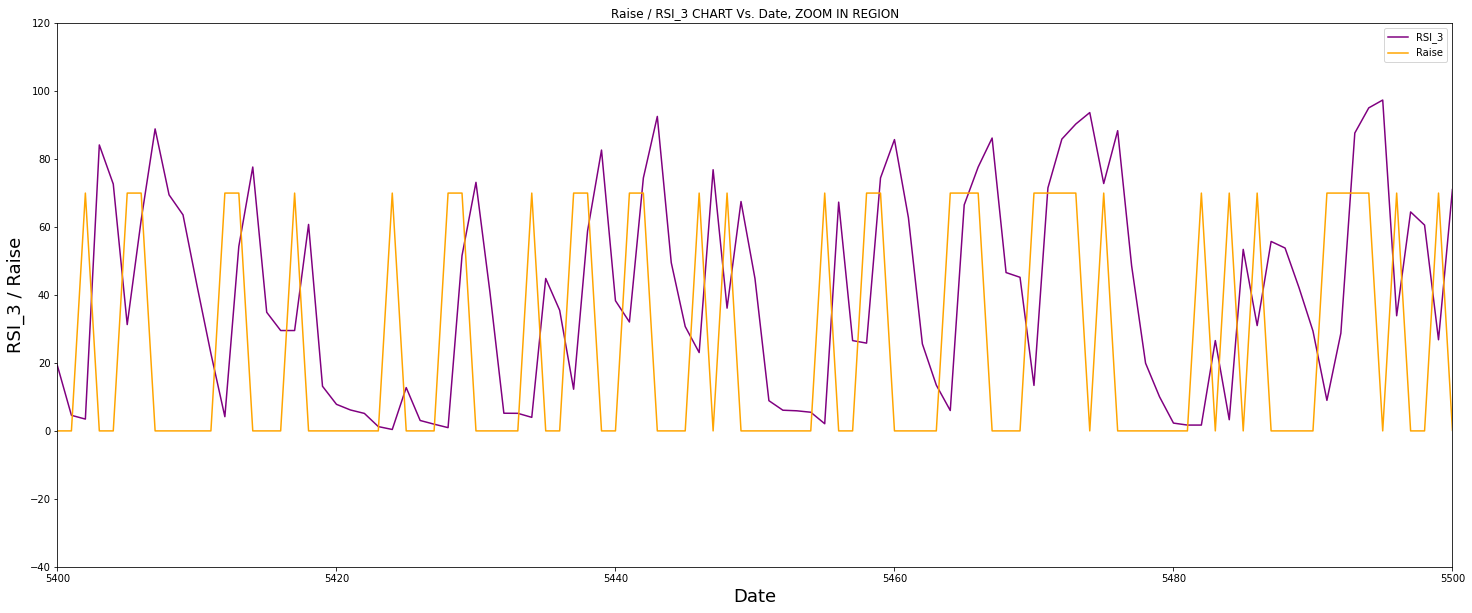

In [ ]:
#graphing RSI_3 vs Raise.
plt.figure(figsize=(25,10))
plt.title('Raise / RSI_3 CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['RSI_3'], label='RSI_3', color='purple')
plt.plot(df['Raise']*70, label='Raise', color='orange')
plt.xlim(5400,5500)
plt.ylim(-40,120)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI_3 / Raise', fontsize = 18)

In the graph above we can see the strong connection between RSI_3 to Raise.

In [ ]:
# Our new DataFrame

df

,Date,Open,Mid,High,Low,Close,Adj Close,Volume,Raise,Day,Month,Year,RSI_10,SMA_10,RSI_3,SMA_3,SMA_SUB,OBV,OBV_EMA,OBV_SUB
4,18/12/1980,0.118862,0.119141,0.119420,0.118862,0.118862,0.093777,73449600.0,1,5,12,1980,40.946642,0.093337,60.716676,0.092456,0.000881,0.000000e+00,0.000000e+00,0.000000e+00
5,19/12/1980,0.126116,0.126395,0.126674,0.126116,0.126116,0.099500,48630400.0,1,6,12,1980,65.822746,0.097189,86.249902,0.096639,0.000550,4.863040e+07,3.039400e+07,1.823640e+07
6,22/12/1980,0.132254,0.132533,0.132813,0.132254,0.132254,0.104343,37363200.0,1,2,12,1980,76.833681,0.101592,93.452536,0.101921,-0.000330,8.599360e+07,5.876114e+07,2.723246e+07
7,23/12/1980,0.137835,0.138114,0.138393,0.137835,0.137835,0.108746,46950400.0,1,3,12,1980,83.339997,0.106764,96.646568,0.106545,0.000220,1.329440e+08,9.285253e+07,4.009147e+07
8,24/12/1980,0.145089,0.145368,0.145647,0.145089,0.145089,0.114469,48003200.0,1,4,12,1980,88.794229,0.113148,98.521513,0.111607,0.001541,1.809472e+08,1.310615e+08,4.988567e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,26/08/2020,126.180000,126.037498,126.992500,125.082497,126.522499,126.522499,163022400.0,0,4,8,2020,86.596768,125.553749,85.285161,125.673748,-0.119999,1.597263e+11,1.596261e+11,1.002324e+08
10012,27/08/2020,127.142502,125.658749,127.485001,123.832497,125.010002,125.010002,155552400.0,0,5,8,2020,68.696322,125.291250,45.989523,125.766250,-0.475000,1.598893e+11,1.597314e+11,1.579529e+08
10013,28/08/2020,126.012497,125.509998,126.442497,124.577499,124.807503,124.807503,187630000.0,1,6,8,2020,66.251621,126.344999,40.938688,124.908752,1.436247,1.597338e+11,1.597323e+11,1.440273e+06
10014,31/08/2020,127.580002,128.500000,131.000000,126.000000,129.039993,129.039993,225702700.0,1,2,8,2020,83.055952,128.259373,89.436360,126.923748,1.335625,1.595461e+11,1.596578e+11,-1.117138e+08


In [ ]:
#Choosing our features.

#for Random Forest, and Neural Networks: everything except Date, Raise and Adj-Close.
X = np.asarray(df.drop(['Date','Raise','High','Low','Adj Close','Close','Year','Volume','RSI_10', 'SMA_10', 'SMA_3','OBV','OBV_EMA'],1))

#for Neural Networks with raw data, Low, High, Mid prices, Open, Close prices, Volume
Xx = np.asarray(df.drop(['Date','Raise','Adj Close','Day','Year','Month','RSI_10', 'SMA_10', 'SMA_3','OBV','OBV_EMA','RSI_3', 'SMA_3', 'OBV_SUB', 'SMA_SUB'],1))

#For Decision Tree and Logistic Regression, features: RSI_3, SMA_SUB, OBV_SUB
XX = np.asarray(df.drop(['Date','Raise','High','Mid', 'Low','Adj Close','Open','Close','Day','Year','Month','Volume','RSI_10', 'SMA_10', 'SMA_3','OBV','OBV_EMA'],1))

In [ ]:
#choosing the target

Y = np.asarray(df['Raise'])

In [ ]:
np.mean(Y), np.mean(1-Y)

(0.4960543402257517, 0.5039456597742483)

Above, we see that about 49.57% of the days in this dataset had indicated a raise in the stocks' price, while 65% do not. This means we can get an accuracy of ~50% without any model.

**2-3) Using Decision Tree and Logistic Regression**

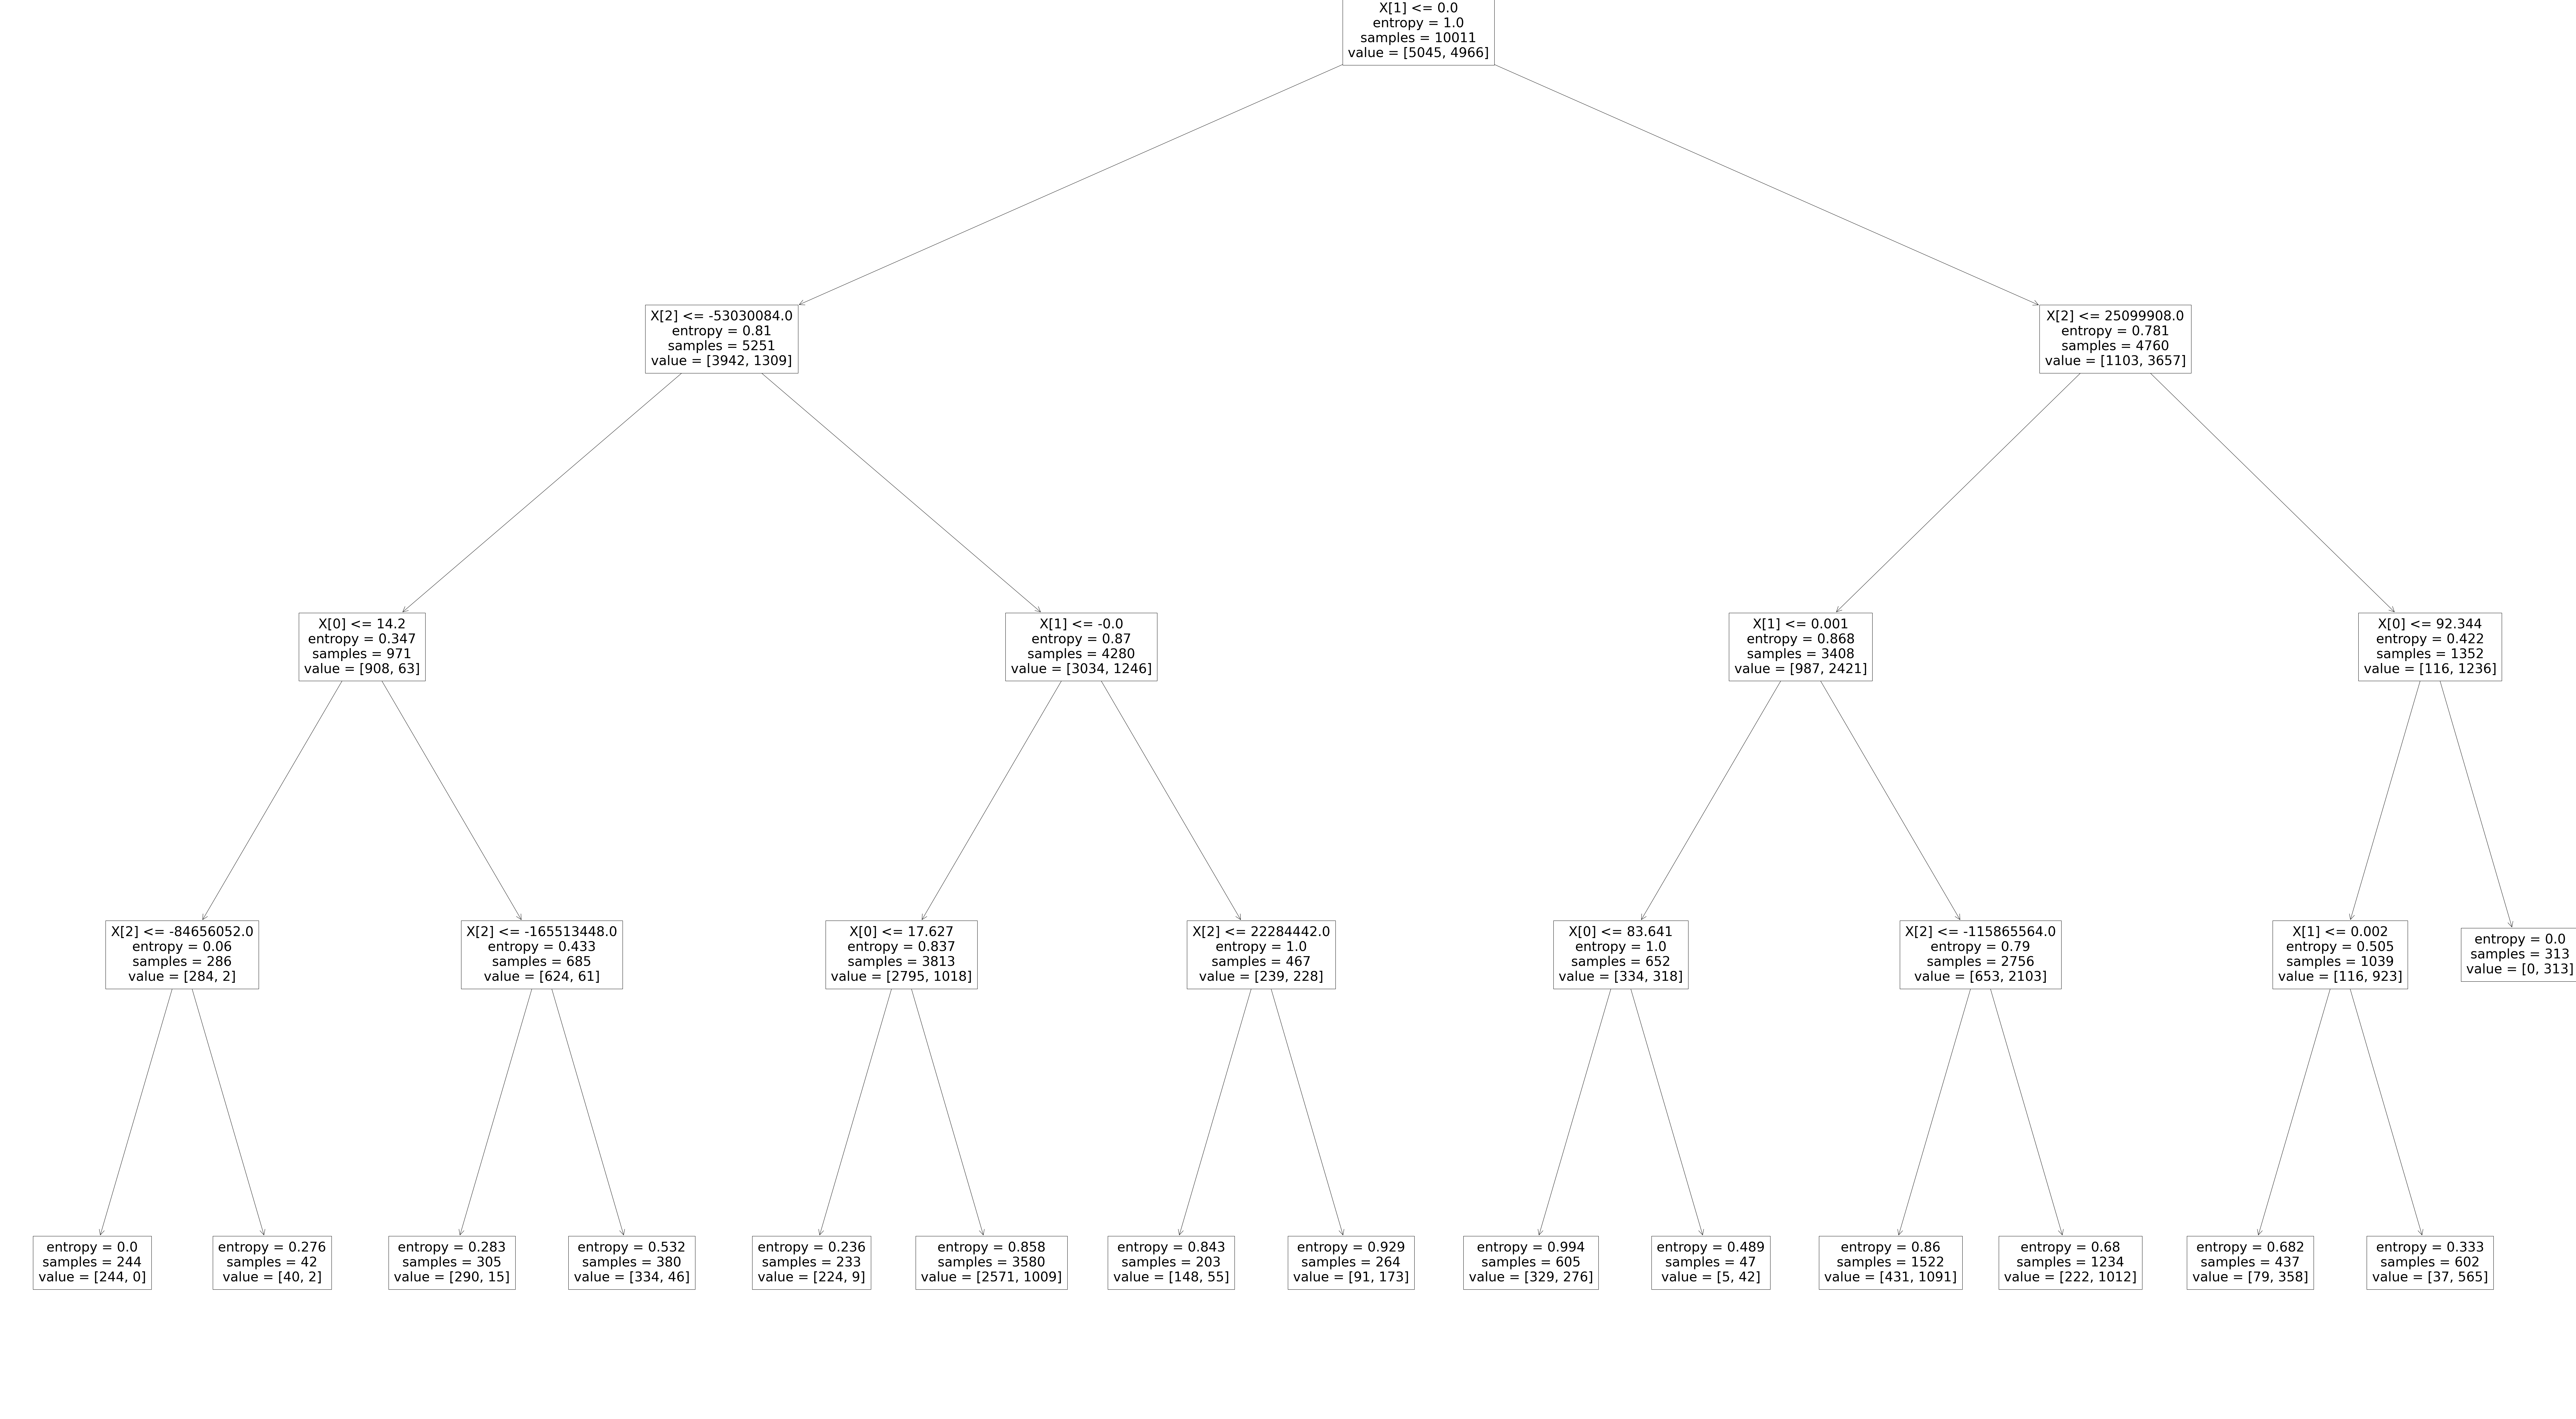

Average Accuracy with CV, of DT with depth 4 is: 0.764
Average Accuracy without CV, of DT with depth 4 is: 0.773
Average precision_weighted of  DT with depth  4  is:  0.773
Average recall_weighted of  DT with depth  4  is:  0.764
Average f1 score with depth 4 is: 0.768


In [ ]:
model_tree = tree.DecisionTreeClassifier()
model_tree.max_depth = 4
model_tree.criterion = 'entropy'
model_tree = model_tree.fit(XX, Y)
plt.figure(figsize=(132, 80), dpi=80)
tree.plot_tree(model_tree)
plt.show()
ancv = model_tree.score(XX,Y)
accuracy = cross_val_score(model_tree, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy with CV, of DT with depth", model_tree.max_depth, "is:", round(accuracy.mean(),3))
print("Average Accuracy without CV, of DT with depth", model_tree.max_depth, "is:", round(ancv.mean(),3))
precision = cross_val_score(model_tree, XX, Y, scoring='precision_weighted', cv=10)
print("Average precision_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(precision.mean(),3))
recall = cross_val_score(model_tree, XX, Y, scoring='recall_weighted', cv=10)
print("Average recall_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(recall.mean(),3))
f1 = 2*recall.mean()*precision.mean()/(recall.mean()+precision.mean())
print("Average f1 score with depth",model_tree.max_depth, "is:", round(f1.mean(),3))

[[4180  865]
 [1412 3554]]


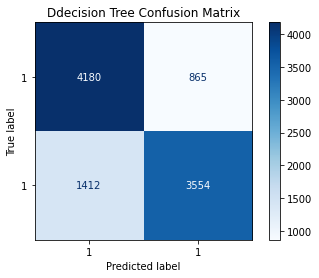

In [ ]:
disp = plot_confusion_matrix(model_tree, XX, Y,
                              display_labels=Y,
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Ddecision Tree Confusion Matrix")
plt.show()

Let's see how Logistic Regression does:

In [ ]:
#newton-cg yields way better results compared to the other solvers

model_lr = LogisticRegression(solver='newton-cg', max_iter=1000)
model_lr.fit(XX, Y)
accuracy = model_lr.score(XX, Y)
print("Average Accuracy of logistic without CV at is: ", round(accuracy.mean(),3))
accuracy = cross_val_score(model_lr, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy of logistic with CV is: ", round(accuracy.mean(),3))

Average Accuracy of logistic without CV at is:  0.571
Average Accuracy of logistic with CV is:  0.508


[[3626 1419]
 [2877 2089]]


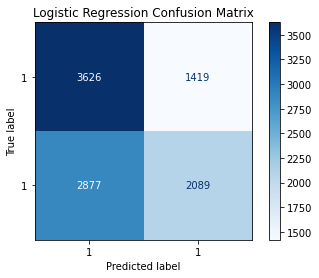

In [ ]:
disp = plot_confusion_matrix(model_lr, XX, Y,
                              display_labels=Y,
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

**4-6) RF & Using Keras to Build and Train Neural Networks**

First, let's get a baseline performance using Random Forest

In [ ]:
# Split the data to Train, and Test (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=11111)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores.
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

accuracy is 0.785
roc-auc is 0.868


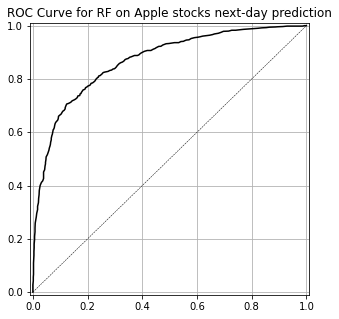

In [ ]:
# Print model performance and plot the roc curve
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Apple stocks next-day prediction'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

Let's use the Keras package to quickly build and train a neural network

In [ ]:
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

After trying many different neual network structures, the following worked the best for us.

In [ ]:
# Define the Model 
# Input size is 17-dimensional
# 4 hidden layers, 165 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(32, input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dense(32, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [ ]:
# This is a nice tool to view the model you have created and count the parameters
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 32)                256       
                                                                 
 dense_64 (Dense)            (None, 32)                1056      
                                                                 
 dense_65 (Dense)            (None, 64)                2112      
                                                                 
 dense_66 (Dense)            (None, 64)                4160      
                                                                 
 dense_67 (Dense)            (None, 64)                4160      
                                                                 
 dense_68 (Dense)            (None, 64)                4160      
                                                                 
 dense_69 (Dense)            (None, 1)                

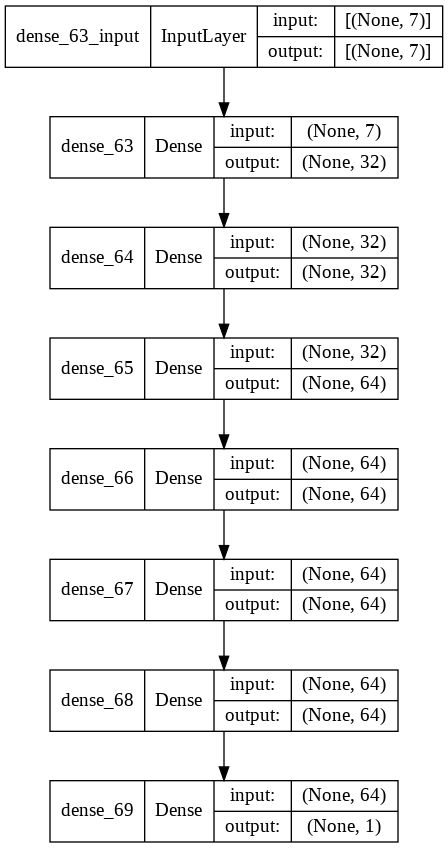

In [ ]:
# This is another tool to view the model you have created and count the parameters
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(learning_rate = 0.01), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=128)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
59/59 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6930 - val_accuracy: 0.5114
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5078
Epoch 3/100
59/59 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5060 - val_loss: 0.6928 - val_accuracy: 0.5122
Epoch 4/100
59/59 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5076 - val_loss: 0.6927 - val_accuracy: 0.5138
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5131 - val_loss: 0.6925 - val_accuracy: 0.5162
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5123 - val_loss: 0.6924 - val_accuracy: 0.5138
Epoch 7/100
59/59 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5111 - val_loss: 0.6923 - val_accuracy: 0.5170
Epoch 8/100
5

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

accuracy is 0.573
roc-auc is 0.621


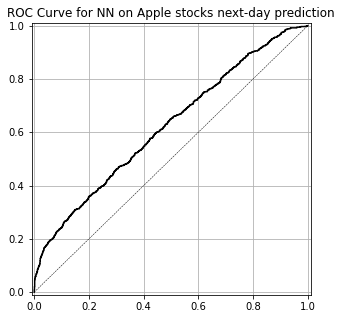

In [ ]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

In [ ]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

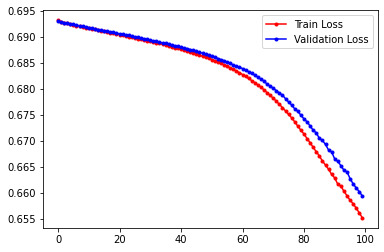

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
## Use this in case the losses are still going down on both the training set and validation set in the graph above!
## Note that when we call "fit" again, it picks up where it left off

run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1700, batch_size=128)

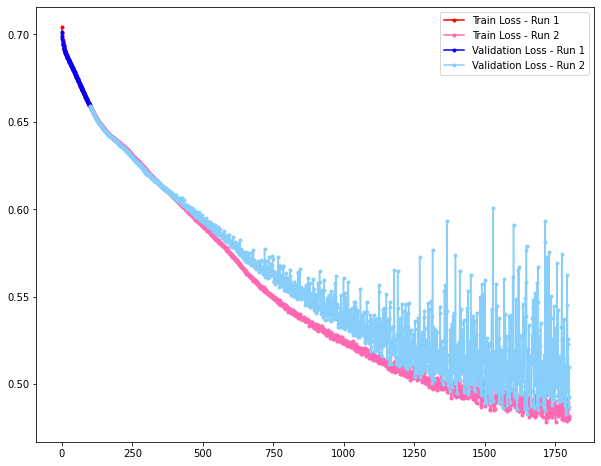

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Both train and validation losses are going down, this indicates we don't have overfitting. We can see the more we train the network the noisier the graph gets. This is expected as the stock market can be often unpredictable to say the least.

accuracy is 0.747
roc-auc is 0.819


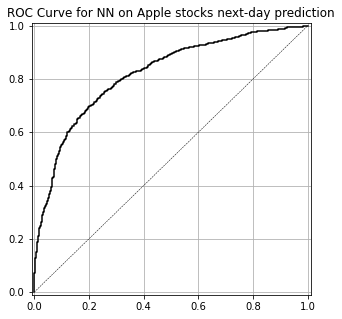

In [ ]:
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but we should get results similar to the Random Forest.

Let's train the same neural network this time with raw data instead of the storngly Raise-related indicators we have described earlier and compare the results. You'll see that the neural network hardly learns anything in this method as the accuracy is ~52%.

In [ ]:
# Split the data to Train, and Test (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(Xx, Y, test_size=0.25, random_state=11111)

In [ ]:
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications
## Scaling the stock values in order to reduce memory usage

normalizer = MinMaxScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
# Define the Model 
# Input size is 17-dimensional
# 4 hidden layers, 165 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(32,input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dense(64,input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dropout(0.02),
    Dense(8,activation="sigmoid"),
    Dense(1, activation="sigmoid")
])

In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(RMSprop(rho = 0.99, learning_rate=0.003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=50)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
## Use this in case the losses are still going down on both the training set and validation set in the graph above!
## Note that when we call "fit" again, it picks up where it left off

run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=500, batch_size=50)

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

It looks like the validation loss has stabilized. This suggests that our network will not benefit from further training.

In [ ]:
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

**7) Testing 1-6 on Amazon stocks**

In [ ]:
#getting the dataset
url = 'https://raw.githubusercontent.com/GilSasson/ai/main/Amazon.csv'
df=pd.read_csv(url,  header=0, error_bad_lines=False) 
#put data in dataset without header line
# rawdataset = np.array(df)

The following code is used if there are null rows in the dataset.
Since there aren't any in the Amazon dataset it has no use

In [ ]:
# #there aren't any null rows in this dataset.

# print("shape off dataframe before drop:",df.shape)
# # print("shape of np before drop:",rawdataset.shape)
# null_row = np.where(df['Low'].isnull()) 
# # dataset = np.delete(rawdataset,(null_row[0][0]), axis=0)
# # print("shape of np after drop:",dataset.shape)
# df.drop(null_row[0][0], axis=0, inplace = True)
# print("shape of dataframe after drop:",df.shape)
# print("row where we found null is:")
# nullrow = null_row[0][0] # we had a null row here
# nullrow

In [ ]:
#Creating new features with our given data:
High = df['High'].to_numpy()
Low = df['Low'].to_numpy()
Mid = (High+Low)/2.0
Close = df['Close'].to_numpy()
Open = df['Open'].to_numpy()
Volume = df['Volume'].to_numpy()
df.insert(2, "Mid", Mid, True)
df['RSI_10'] = computeRSI(df['Adj Close'], 10)
df['SMA_10'] = movingaverage(df['Adj Close'], 10)
df['RSI_3'] = computeRSI(df['Adj Close'], 3)
df['SMA_3'] = movingaverage(df['Adj Close'], 3)
df['SMA_SUB'] = df['SMA_10']-df['SMA_3']

In [ ]:
#dropping nan values if such exists from df

print("shape off dataframe before drop:",df.shape)
dfrowsold = df.shape[0] # will be used for OBV calc
df.dropna(subset = ["RSI_10"], inplace=True)
print("shape of dataframe after drop:",df.shape)
dfrowsnew = df.shape[0] # will be used for OBV calc

The code below is slightly different than the one in the Apple stocks example because we had no null rows in the Amazon dataset.

In [ ]:
#Calculation of On Balance Volume [3] (See References):
#If the closing price is above the prior close price then: Current OBV = Previous OBV + Current Volume
#If the closing price is below the prior close price then: Current OBV = Previous OBV - Current Volume
#If the closing prices equals the prior close price then: Current OBV = Previous OBV (no change)

OBV = []
OBV.append(0)
for i in range(11, len(df.Close)+10):
  if df.Close[i] > df.Close[i-1]:
    OBV.append(OBV[-1] + df.Volume[i])
  elif df.Close[i] < df.Close[i-1]: 
    OBV.append(OBV[-1] - df.Volume[i])
  else:
    OBV.append(OBV[-1])

len(OBV)
#let's store the OBV and the EMA (exponential moving average) into new columns. [4] 
df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(span=10).mean()
df['OBV_SUB'] = df['OBV']-df['OBV_EMA']

In [ ]:
# Our new DataFrame

df

In [ ]:
#Choosing our features.

#for Random Forest, and Neural Networks: everything except Date, Raise and Adj-Close.
X = np.asarray(df.drop(['Date','Raise','Adj Close'],1)) #for Random Forest

#for Neural Networks with raw data, Low, High, Mid prices, Open, Close prices, Volume
Xx = np.asarray(df.drop(['Date','Raise','Adj Close','Day','Year','Month','RSI_10', 'SMA_10', 'SMA_3','OBV','OBV_EMA','RSI_3', 'SMA_3', 'OBV_SUB', 'SMA_SUB'],1))

#For Decision Tree and Logistic Regression, features: RSI_3, SMA_SUB, OBV_SUB
XX = np.asarray(df.drop(['Date','Raise','High','Mid', 'Low','Adj Close','Open','Close','Day','Year','Month','Volume','RSI_10', 'SMA_10', 'SMA_3','OBV','OBV_EMA'],1))

In [ ]:
#choosing the target

Y = np.asarray(df['Raise'])

In [ ]:
np.mean(Y), np.mean(1-Y)

In [ ]:
model_tree = tree.DecisionTreeClassifier()
model_tree.max_depth = 4
model_tree.criterion = 'entropy'
model_tree = model_tree.fit(XX, Y)
plt.figure(figsize=(132, 80), dpi=80)
tree.plot_tree(model_tree)
plt.show()
ancv = model_tree.score(XX,Y)
accuracy = cross_val_score(model_tree, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy with CV, of DT with depth", model_tree.max_depth, "is:", round(accuracy.mean(),3))
print("Average Accuracy without CV, of DT with depth", model_tree.max_depth, "is:", round(ancv.mean(),3))
precision = cross_val_score(model_tree, XX, Y, scoring='precision_weighted', cv=10)
print("Average precision_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(precision.mean(),3))
recall = cross_val_score(model_tree, XX, Y, scoring='recall_weighted', cv=10)
print("Average recall_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(recall.mean(),3))
f1 = 2*recall.mean()*precision.mean()/(recall.mean()+precision.mean())
print("Average f1 score with depth",model_tree.max_depth, "is:", round(f1.mean(),3))

In [ ]:
disp = plot_confusion_matrix(model_tree, XX, Y,
                              display_labels=Y,
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Ddecision Tree Confusion Matrix")
plt.show()

In [ ]:
#newton-cg yields way better results compared to the other solvers (+ ~30%)

model_lr = LogisticRegression(solver='newton-cg', max_iter=1000)
model_lr.fit(XX, Y)
accuracy = model_lr.score(XX, Y)
print("Average Accuracy of logistic without CV at is: ", round(accuracy.mean(),3))
accuracy = cross_val_score(model_lr, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy of logistic with CV is: ", round(accuracy.mean(),3))

In [ ]:
disp = plot_confusion_matrix(model_lr, XX, Y,
                              display_labels=Y,
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

First, let's get a baseline performance using Random Forest

In [ ]:
# Split the data to Train, and Test (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=11111)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores.
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

In [ ]:
# Print model performance and plot the roc curve
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Amazon stocks next-day prediction'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

Let's use the Keras package to quickly build and train a neural network

In [ ]:
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications
## Scaling the stock values in order to reduce memory usage

normalizer = MinMaxScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
# Define the Model 
# Input size is 17-dimensional
# 4 hidden layers, 165 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(32,input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dense(64,input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dropout(0.02),
    Dense(8,activation="sigmoid"),
    Dense(1, activation="sigmoid")
])

In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=50)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [ ]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
## Use this in case the losses are still going down on both the training set and validation set in the graph above!
## Note that when we call "fit" again, it picks up where it left off

run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1300, batch_size=50)

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

In [ ]:
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

# **Data Setup**
First we have updated the excel file by adding a new binary 'Raise' culomn which indicates if the stocks' price went up or not. We did that using the 'Adj Close' culomn by checking if

AdjClose [j+1] > AdjClose [j]

Then Raise [j+1]=1, otherwise Raise [j+1]=0

We then created new fields like the day of the month and year.
We saw that using the raw data as is doesn't yield much of anything and training a neural network this way gives merely 51% accuracy which is equivalent to deciding the result by tossing a coin. We then added a 'Mid' prices culomn which is the maximum stocks' price plus the minimum stocks' price on a given day, divided by two

Mid [j] = (High [j] + Low [j]) / 2

Our models showed slightly better results (+ ~1% accuracy) thanks to the 'Mid' feature. That helped us realizing that creating new features is necessary and that indicators which are short-period based (3 to 10 days) is probably the way to go to improving our models' accuracy.

We quickly learnt that such stock market indicators already exists, no surprise there, and decided to try some of them. Relative Strength Indicator (RSI) [4], On-balance volume (OBV) [5] and Simple Moving Average [6] greatly improved our results.

In our Random Forest, Neural Network models we used just one train / test split whereas in our Logistic Regression, Decison Tree models we used cross-validation.

# **Machine Model Logic**

We tried different kind of machine models such as
Logistic Regression, Decision Tree, Random Forest & Neural Network.

For our neural network we defined the following:

- Input size is 17-dimensional

- Four hidden layers, with a total of 168 hidden nodes (32-64-64-8), two layers with relu activation, one dropout layer & one sigmoid activation layer.

- Final layer has just one node with a sigmoid activation

- SGD optimizer

- Binary cross entropy loss function

# **References**

[1] https://tcoil.info/compute-rsi-for-stocks-with-python-relative-strength-index/

[2] https://www.youtube.com/watch?v=5-SV_xXQ_wE

[3] https://www.kaggle.com/kratisaxena/stock-market-technical-indicators-visualization/notebook

[4] https://www.youtube.com/watch?v=MRGXd8eaWB4

[5] https://en.wikipedia.org/wiki/Relative_strength_index

[6] https://en.wikipedia.org/wiki/On-balance_volume

[7] https://en.wikipedia.org/wiki/Moving_average
